<a target="_blank" href="https://colab.research.google.com/github/dahenderson98/ImageStyleTransfer/blob/main/styletransfer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving raptor2.jpeg to raptor2 (1).jpeg

Upload Style Image


Saving orange-style.jpg to orange-style (2).jpg
Content Path: <_io.BytesIO object at 0x7f167e35a770>
Style Path: <_io.BytesIO object at 0x7f167e35aef0>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


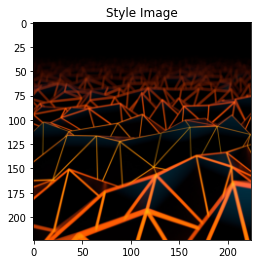

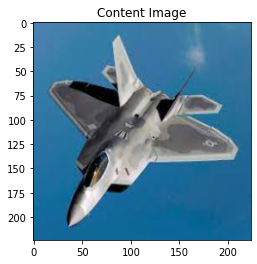

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [ ]:
import torchvision.models as models

# use 3 different vgg16 models (1 for style, 1 for content, 1 for new image)
# Run style image and new image thru network, pull activation layers and get loss between them, send loss back through new image
# Run content image and new image thru network, pull an activation layer and get loss between them, send loss back through new image

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_layers = [19]
style_layers = [0, 5, 10, 17, 24]
new_img_layers = [19, 0, 5, 10, 17, 24]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
content_model = VGGIntermediate(content_layers).eval()
content_model.cuda()
style_model = VGGIntermediate(style_layers).eval()
style_model.cuda()
newimg_model = VGGIntermediate(new_img_layers).eval()
newimg_model.cuda()

# Cache the outputs of the content and style layers for their respective images
#with torch.no_grad():
  #l_content_dict = content_model.forward(content_image)
  #l_style_dict = style_model.forward(style_image)
  #l_generated_dict = newimg_model.forward(content_image)


<ipython-input-85-ff24df4209a9>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-85-ff24df4209a9>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


VGGIntermediate(
  (norm): Normalization()
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kerne

___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [ ]:
def gram_matrix(input):
  a, b, c, d = input.size()
  input = input.view(a*b,c*d)
  return torch.mm(input, input.t()).div(a * b * c * d)
  
class ContentLoss(nn.Module):
  # flatten each feature map (channel)
  # H x W across, C rows
  # output(model x new image) - output(model x content image)
  def __init__(self):
    super(ContentLoss, self).__init__()

  def forward(self, content_img, new_img):
    #content_flat = torch.flatten(content_img, start_dim=1, end_dim=2)
    #new_img_flat = torch.flatten(new_img, start_dim=1, end_dim=2)

    #return torch.mul( 0.5, torch.sum( torch.square( torch.subtract( new_img_flat, content_flat ) ) ) )
    return F.mse_loss( new_img, content_img )
    
class StyleLoss(nn.Module):
  # Graham matrix (at each layer, one matrix for style image and one for new image)
  #   means dot product between all pairs of features 
  #   matrix multiply matrix of all feature maps by that matrix' transpose
  #   x2
  # 1/(4*N^2*M^2) * sum( (new_image_graham - style_image_graham)^2 )
  
  def __init__(self):
    super(StyleLoss, self).__init__()

  def forward(self, style_imgs, new_imgs, ):
    A = gram_matrix(new_imgs) # g
    G = gram_matrix(style_imgs) # a
    G = G.detach()

    return 10000 * F.mse_loss(G, A)


# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison
#content_loss = ContentLoss()

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
#style_loss = StyleLoss()

In [ ]:
#content_loss.forward(l_content_dict[19], l_generated_dict[19]).item()

In [ ]:
#print(l_content_dict)

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**




Epoch:  0
Content Loss:  0.0
Style Loss:  6222.99462890625

Epoch:  50
Content Loss:  118.44265747070312
Style Loss:  280.3833312988281

Epoch:  100
Content Loss:  109.52998352050781
Style Loss:  187.89720153808594

Epoch:  150
Content Loss:  90.29512786865234
Style Loss:  248.50080108642578

Epoch:  200
Content Loss:  102.930419921875
Style Loss:  189.8148193359375

Epoch:  250
Content Loss:  95.46601104736328
Style Loss:  158.27185821533203

Epoch:  300
Content Loss:  81.6760025024414
Style Loss:  265.50057220458984

Epoch:  350
Content Loss:  109.39566802978516
Style Loss:  202.75432586669922

Epoch:  400
Content Loss:  86.48919677734375
Style Loss:  175.38360595703125

Epoch:  450
Content Loss:  98.25608825683594
Style Loss:  156.37283325195312

Epoch:  500
Content Loss:  104.67859649658203
Style Loss:  175.00371551513672

Epoch:  550
Content Loss:  81.08671569824219
Style Loss:  157.45144653320312

Epoch:  600
Content Loss:  104.93196868896484
Style Loss:  181.5452651977539

Epoc

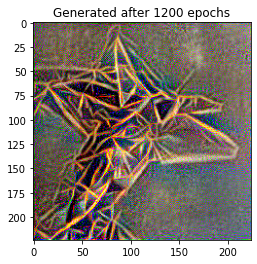

In [ ]:
# Start with a copy of the content image
#generated_img = content_image.clone()
#generated_img.requires_grad = True

# Print content and style images

generated_img = nn.Parameter(content_image.clone())

content_objective = ContentLoss()
style0_objective = StyleLoss()
style1_objective = StyleLoss()
style2_objective = StyleLoss()
style3_objective = StyleLoss()
style4_objective = StyleLoss()

content_dict = content_model(content_image)
style_dict = style_model(style_image)

optimizer = optim.Adam([generated_img], lr=0.1)

epochs = 1200

for epoch in range(epochs):
  #print(epoch)

  # Run the optimizer on the images to change the image
  #  using the loss of the style and content layers
  #  to backpropagate errors 

  optimizer.zero_grad()


  generated_dict = newimg_model(generated_img)

  # Calculate and propogate loss
  total_loss = 0
  #print("Total Loss: ",total_loss)

  total_loss += content_objective(content_dict[19], generated_dict[19])
  #print("Total Loss: ",total_loss)
  if epoch % 50 == 0:
    c = total_loss.clone().detach().item()
    print("\nEpoch: ",epoch)
    print("Content Loss: ",c)

  total_loss += style0_objective(style_dict[0], generated_dict[0])
  #print("Total Loss: ",total_loss)

  total_loss += style1_objective(style_dict[5], generated_dict[5])
  #print("Total Loss: ",total_loss)
  
  total_loss += style2_objective(style_dict[10], generated_dict[10])
  #print("Total Loss: ",total_loss)
  
  total_loss += style3_objective(style_dict[17], generated_dict[17])
  #print("Total Loss: ",total_loss)
  
  total_loss += style4_objective(style_dict[24], generated_dict[24])
  #print("Total Loss: ",total_loss)
  if epoch % 50 == 0:
    s = total_loss.clone().detach().item()
    print("Style Loss: ",s - c)
  
  # Push total loss back through generated image
  total_loss.backward(retain_graph=True)

  optimizer.step()

  
# turtle + wave => 250 epochs
# turtle + paisley => 100 epochs
# lion + paisley => 100 epochs
# nechtarfront + starry night => 250 epochs
# dallin + vangogh => 500 epochs


generated_img = torch.clamp(generated_img, min=0, max=1)
# Show generated image
display(generated_img, title=f'Generated after {epochs} epochs')


In [ ]:
torch.cuda.memory_allocated() / 1e9

1.84345856

In [ ]:
print(generated_img)

tensor([[[[0.9398, 0.3757, 0.2538,  ..., 0.8277, 0.7281, 0.9874],
          [0.0000, 0.4944, 0.4405,  ..., 0.6201, 0.1148, 0.5575],
          [0.3982, 0.7307, 0.2452,  ..., 0.4675, 0.7587, 0.6264],
          ...,
          [0.7364, 0.3505, 0.0000,  ..., 0.5161, 0.4993, 0.6782],
          [0.0000, 0.1449, 0.5040,  ..., 0.3886, 0.3384, 0.1284],
          [0.0000, 0.0000, 0.2939,  ..., 0.3855, 0.7270, 0.4094]],

         [[0.2996, 0.1539, 0.5934,  ..., 0.2750, 0.4996, 0.3463],
          [0.4088, 0.0978, 0.4915,  ..., 0.6752, 0.4587, 0.3927],
          [0.6424, 0.0824, 0.4041,  ..., 0.5226, 0.4496, 0.4462],
          ...,
          [0.4951, 0.0000, 0.0455,  ..., 0.3771, 0.3093, 0.4272],
          [0.7384, 0.1845, 0.1640,  ..., 0.4783, 0.3607, 0.6008],
          [0.4445, 0.0000, 0.0000,  ..., 0.6486, 0.6238, 0.8560]],

         [[0.0000, 0.6081, 0.0000,  ..., 0.6520, 0.2821, 0.0822],
          [0.4941, 0.6848, 0.0000,  ..., 0.0515, 1.0000, 0.6744],
          [0.0000, 0.4848, 0.1723,  ..., 0

In [ ]:
gc.collect()

8394

In [ ]:
print(torch.cuda.memory_allocated() / 1e9)

1.528449536


### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

P10eq1: 

This equation takes the content output layer (P) and subtracts it from the generated image output layer (F). It then squares the tensor from that subtraction sums over every value (at row i, column j) in it, and multiplies it by 0.5. At a high level, this equation finds the mean squared error between content and generated layers. 

P11eq3: 

This equations essentially builds a distance matrix between all possible pairs of channels from an output activation layer. A dot product is taken between every channel layer and all other channel layers, with the resultant products being represented in a symmetric matrix. This equation finds the similarity between all chnnels (features) of an output layer 

P11eq4: 

This equation first subtracts the graham matrix of the style output layer (A) from the graham matrix of the generated output layer (G). It then squares the result of that subtraction operation and sums across all of its elements (at row i, column j). It then divides that square by the product of 4, the number of channels in the original output layer, the width of the original output layer, and the height of the original output layer. At a high level, this equation finds the mean squared error between the graham matrices of G and A, then scales that error down by the dimensions of G, which match the dimensions of A.

P11eq5: 

This equation sums the outputs of the previous equation, each scaled loss  (E) being multiplied by a style weight (W). This allows the system to propogate the total loss of all style and generated output layers after scaling them in a way that allows you to balance the effect of style loss versus content loss. 